# Media Test Data

I will shortly follow the Cross-Industry Standart Process - Data Mining (CRISP-DM) method.

The first stage - Business Understanding: the main importance behind the business is knowing in what extend the revenue will increase after the campaign and  which campaign is more reliable (to what campaign we should send more money).

The following steps: Data Understanding, Data Preparation, Modeling, Validation, Presentation will be described in the next parts.


In [34]:
#Import libraries
import pandas as pd
from statsmodels.tsa.arima_model import ARIMA
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
%matplotlib inline

In [35]:
#Data loading
data = pd.read_csv("TV_test_business_case_data.csv")

### Data Understanding

In [36]:
#Examples od the data
data.head()

,Week_Number,Campaign_Period,Control_Traffic,Control_Revenue,VOD_Test_Traffic,VOD_Test_Revenue,TV_Test_Traffic,TV_Test_revenue
0,1,Pre-Campaign,78238,157199.00,90430,155833.00,108567,184196.63
1,2,Pre-Campaign,73928,154791.50,81719,131896.50,99358,166628.38
2,3,Pre-Campaign,70708,154294.88,79183,138340.63,97299,168193.13
3,4,Pre-Campaign,75175,161920.63,85428,145610.00,103628,190280.88
4,5,Pre-Campaign,70744,147408.75,79372,130653.13,96936,154984.75


In [37]:
#Unique campaign periods
data.Campaign_Period.unique()

array(['Pre-Campaign', 'Campaign', 'Post-Campaign'], dtype=object)

We can see that we have 3 different periods: before campaign, during campaign and after campaign.

In [38]:
#Numerical data description
data.describe()

,Week_Number,Control_Traffic,Control_Revenue,VOD_Test_Traffic,VOD_Test_Revenue,TV_Test_Traffic,TV_Test_revenue
count,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000
mean,32.500000,85431.843750,185183.744844,104042.796875,179069.260469,125428.234375,218826.957500
std,18.618987,14750.277192,35808.120486,21623.009872,39747.564206,24821.350706,46730.025082
min,1.000000,47652.000000,91045.880000,51693.000000,81787.130000,66685.000000,107303.250000
25%,16.750000,79245.250000,167369.282500,96594.000000,157228.097500,114334.750000,194916.625000
50%,32.500000,86570.000000,190928.940000,106354.000000,182669.190000,126650.500000,222498.315000
75%,48.250000,94711.750000,210025.817500,117061.500000,206731.812500,140216.500000,254228.692500
max,64.000000,139355.000000,270772.000000,169659.000000,304690.000000,197149.000000,342062.880000


We see that, column names of revenue VOD and TV are written differently. To make next steps easier we will change the names to the identical

In [39]:
#Create the new column with correct name and delete the old
data['TV_Test_Revenue'] = data['TV_Test_revenue']
data = data.drop('TV_Test_revenue',  axis=1)

In [40]:
#Function to plot VOD and TV data, to compare which has more traffic and revenue
def plot_to_compare(data, label):
    #Plot VOD data
    plt.plot(data.Week_Number, data['VOD_Test_'+label], label='VOD '+label)
    #Plot TV data
    plt.plot(data.Week_Number, data['TV_Test_'+label], label='TV '+label)
    #Plot line between pre campaign and post campaign periods
    plt.axvline(52, color='red')
    plt.title(label)
    plt.legend()
    #Start x axes from 0
    plt.xlim(xmin=0)
    plt.show()

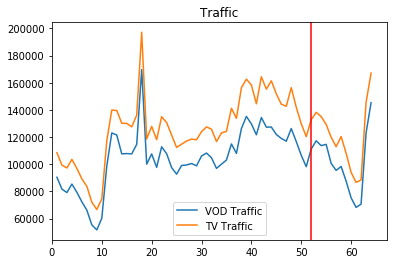

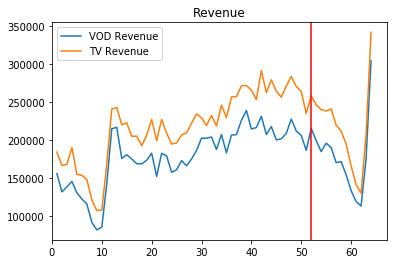

In [41]:
#Compare traffics
plot_to_compare(data, 'Traffic')
#Compare revenues
plot_to_compare(data, 'Revenue')

We can see that, TV provides higher traffic and revenue, than VOD.

### Data Preparation

In [212]:
#Splitting data to pre-campaign + campaign and post_campaign) periods
pre_campaign = data[data.Campaign_Period != 'Post-Campaign']
campaign = data[data.Campaign_Period == 'Post-Campaign']

### Modeling

To solve the task, I will apply the ARIMA algorithm. The reason of chosing this model is being simple and flexible at the same time.

In [166]:
#Mean absolute percentage error
def func_mape(fc, actual):
    return np.mean(np.abs(fc - actual)/np.abs(actual))

In [213]:
#Function to train 
def arima(train_data, actual, p=1, d=0, q=0):
    #ARIMA model
    model = ARIMA(train_data, order=(p,d,q))
    #Fit train data
    model_fit = model.fit(disp=0)
    #Print summary of the training
    print(model_fit.summary())
    #Forecast 12 days (campaign period)
    #Forecasted, standart error, confidence intervals
    fc, se, conf = model_fit.forecast(9, alpha=0.05) 
    #Calculate mean absolute percentage error
    mape = func_mape(fc, actual)
    print("MAPE: {0}".format(mape))
    #Return trained model, forecast values, confidence intervals, standart error and MAPE value
    return model_fit, fc, conf, se, mape

In [214]:
#Train and predict campaign period for VOD traffic
actual_vodt = campaign.VOD_Test_Traffic
model_vodt, fc_vodt, conf_vodt, se_vodt, mape_vodt = arima(pre_campaign.VOD_Test_Traffic, actual_vodt, 10)

#Train and predict campaign period for TV traffic
actual_tvt = campaign.TV_Test_Traffic
model_tvt, fc_tvt, conf_tvt, se_tvt, mape_tvt = arima(pre_campaign.TV_Test_Traffic, actual_tvt, 10)

#Train and predict campaign period for VOD revenue
actual_vodr = campaign.VOD_Test_Revenue
model_vodr, fc_vodr, conf_vodr, se_vodr, mape_vodr = arima(pre_campaign.VOD_Test_Revenue, actual_vodr, 2)
 
#Train and predict campaign period for TV revenue
actual_tvr = campaign.TV_Test_Revenue
model_tvr, fc_tvr, conf_tvr, se_tvr, mape_tvr = arima(pre_campaign.TV_Test_Revenue, actual_tvr, 1)

#The p, d, q values were choosen by testing different values

                              ARMA Model Results                              
Dep. Variable:       VOD_Test_Traffic   No. Observations:                   55
Model:                    ARMA(10, 0)   Log Likelihood                -601.693
Method:                       css-mle   S.D. of innovations          13465.717
Date:                Sat, 24 Aug 2019   AIC                           1227.386
Time:                        14:12:44   BIC                           1251.474
Sample:                             0   HQIC                          1236.701
                                                                              
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    1.067e+05   4822.692     22.128      0.000    9.73e+04    1.16e+05
ar.L1.VOD_Test_Traffic      0.5967      0.134      4.444      0.000       0.334       0.860


### Visualization

In [219]:
def visual(train, actual, fc, conf, label, weeks_train=pre_campaign.Week_Number, weeks_fc=campaign.Week_Number):
    plt.plot(weeks_train, train, label=label+' train')
    plt.plot(weeks_fc, actual, label=label+' actual')
    plt.plot(weeks_fc, fc, label=label+' forecast')
    plt.axvline(56, color='red')
    plt.fill_between(range(56, 65), conf[:,0], conf[:,1], color='k', alpha=.2)
    plt.legend()
    plt.xlim(xmin=0)
    plt.show()

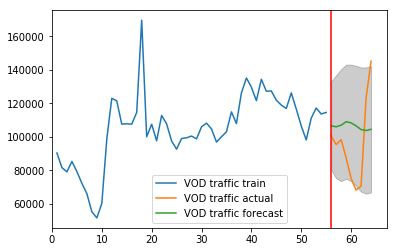

In [220]:
#Visualize train, test and forecasted VOD traffic data with confidence intervals
visual(pre_campaign.VOD_Test_Traffic, actual_vodt, fc_vodt, conf_vodt, 'VOD traffic')

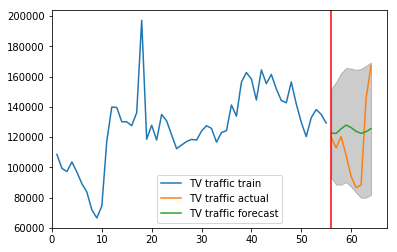

In [221]:
#Visualize train, test and forecasted TV traffic data with confidence intervals
visual(pre_campaign.TV_Test_Traffic, actual_tvt, fc_tvt, conf_tvt, 'TV traffic')

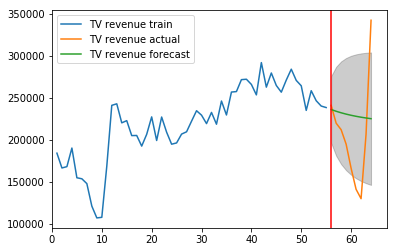

In [222]:
#Visualize train, test and forecasted VOD revenue data with confidence intervals
visual(pre_campaign.TV_Test_Revenue, actual_tvr, fc_tvr, conf_tvr, 'TV revenue')

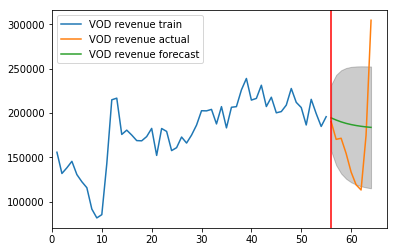

In [223]:
#Visualize train, test and forecasted TV revenue data with confidence intervals
visual(pre_campaign.VOD_Test_Revenue, actual_vodr, fc_vodr, conf_vodr, 'VOD revenue')

We can see that error values for traffic are 0.27 and 0.21, and for revenue are 0.28 for VOD and TV respectively. The calculated error rate shows us being the model reliable, at the same time there is need to improve it.

We can see that there is an anual pattern in the data. It would improve the results if we consider seasionality in our model. But it is not easy as we have train data only capturing one year.

### Estimating the anual incremental traffic anf revenue

To estimate the incremental traffic and revenue, I will forecast values for one year and calculate difference between post-campaign and pre-campaign years.

In [232]:
#Function to calculate incremental value
def increment(train, predicted):
    #Difference between sum of forecasted campaign values and sum of first 12 days of post-campaign period
    return (predicted.sum() - train[:9].sum())

In [233]:
print("VOD Traffic\n")
inc_vodt = increment(pre_campaign.VOD_Test_Traffic, fc_vodt)
print("Incremental value for: \n{0}\n".format(inc_vodt))
print("Standart error: \n{0}\n".format(se_vodt))
print("Confidence intervals: \n{0}\n".format(conf_vodt))
print("Marketing efficiency: \n{0:.2}\n".format(inc_vodt/140000))

VOD Traffic

Incremental value for: 
295026.0842812902

Standart error: 
[13465.7173393  15680.73240335 17048.26823981 17365.8952699
 17742.95328677 18261.77812337 18921.555415   19218.66726317
 19250.38466657]

Confidence intervals: 
[[ 80301.52131926 133086.16334131]
 [ 75346.01135806 136813.35288161]
 [ 73602.90407041 140430.88756803]
 [ 75078.66070136 143151.71927797]
 [ 73630.86192489 143181.96076776]
 [ 70865.1907621  142450.04559303]
 [ 67348.70253198 141519.83682175]
 [ 66170.28380584 141506.07513918]
 [ 66849.93471399 142310.05598405]]

Marketing efficiency: 
2.1



In [234]:
print("TV Traffic\n")
inc_tvt = increment(pre_campaign.TV_Test_Traffic, fc_tvt)
print("Incremental value for: \n{0}\n".format(inc_tvt))
print("Standart error: \n{0}\n".format(se_tvt))
print("Confidence intervals: \n{0}\n".format(conf_tvt))
print("Marketing efficiency: \n{0:.2}\n".format(inc_tvt/140000))

TV Traffic

Incremental value for: 
302850.68054504856

Standart error: 
[14997.33927519 17262.78774182 18785.10453266 19219.55680548
 19924.10554066 20671.43002464 21714.85942085 22194.28422858
 22266.13255394]

Confidence intervals: 
[[ 93252.92180011 152041.4114867 ]
 [ 88627.27149033 156296.15598377]
 [ 88634.30222602 162270.55888567]
 [ 90302.33822596 165641.61650109]
 [ 87227.41500885 165328.47357659]
 [ 83348.89231194 164379.40902642]
 [ 79922.44607937 165043.13086779]
 [ 80089.32676375 167089.3222651 ]
 [ 82008.36641459 169290.00217604]]

Marketing efficiency: 
2.2



In [235]:
print("VOD Revenue\n")
inc_vodr = increment(pre_campaign.VOD_Test_Revenue, fc_vodr)
print("Incremental value for: \n{0}\n".format(inc_vodr))
print("Standart error: \n{0}\n".format(se_vodr))
print("Confidence intervals: \n{0}\n".format(conf_vodr))
print("Marketing efficiency: \n{0:.2}\n".format(inc_vodr/140000))

VOD Revenue

Incremental value for: 
577351.1911824045

Standart error: 
[19053.50227655 25982.92112624 29717.47105748 31886.16657732
 33196.81996463 34006.48293154 34512.95391062 34832.11912718
 35034.15323474]

Confidence intervals: 
[[157213.98219837 231902.33868115]
 [141236.13811365 243087.31735481]
 [131835.06940119 248325.41536972]
 [125900.66782941 250892.1440226 ]
 [121984.34774313 252113.49080702]
 [119320.97566691 252623.93924028]
 [117468.60043272 252756.89376253]
 [116156.4758158  252695.87380478]
 [115212.19749143 252543.55462932]]

Marketing efficiency: 
4.1



In [236]:
print("TV Revenue\n")
inc_tvr = increment(pre_campaign.TV_Test_Revenue, fc_tvr)
print("Incremental value for: \n{0}\n".format(inc_tvr))
print("Standart error: \n{0}\n".format(se_tvr))
print("Confidence intervals: \n{0}\n".format(conf_tvr))
print("Marketing efficiency: \n{0:.2}\n".format(inc_tvr/140000))

TV Revenue

Incremental value for: 
673242.0456344394

Standart error: 
[20268.28645    26958.53214339 31141.19945539 34010.00866059
 36061.54439728 37563.27922576 38678.6527171  39515.1005157
 40146.57838871]

Confidence intervals: 
[[196299.4844204  275749.70736108]
 [181130.03556039 286805.53971462]
 [171128.34261505 293199.60135094]
 [163923.63811131 297240.42228863]
 [158515.34299751 299873.99948863]
 [154355.28651059 301600.635358  ]
 [151102.14276382 302719.67535589]
 [148526.93339891 303423.2811114 ]
 [146468.56368646 303840.25917523]]

Marketing efficiency: 
4.8



We can see that the marketing efficiency is 4.1 and 4.8 for the VOD and TV revenue respectively. The incremental values were calculated for the 9 days of campaign.  

### Conclusion

We used the ARIMA model to train. The tain data includes all pre-campaign and campaign period. The forecasted values includes campaign period. To be able to check the model, I have predicted the campaign period 9 days. Future work will include the using LSTM model in forecast. 

From results we can see that TV media gives higher revenue and traffic. The forecast shows that even in 9 days the campaign will be productive. It will be good having additional data from different years, data about holidays and other events. As well using different  models will improve the results. In business prospectives the forecat can be used to identify incremental revenue beforehand, to identify what is the optimal value to spend on campaign, and to which campaign there is spend more/less. 